Netflix資料視覺化:

處理程序：
1. 資料處理：

    1.1 遺失值處理
    
    1.2 資料轉換
2. 資料視覺化：

    2.1 電視 VS.電影

    2.2 國家發行量比較

    2.3 國家發行類型 IP 比例

    2.4 每年發行量

    2.5 影片種類

    2.6 類型相關性
    
    2.7 文字雲

In [1]:
# 載入套件
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 載入資料
df = pd.read_csv("netflix_titles.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [3]:
# 觀察欄位
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

In [4]:
df.loc[df['type'] == 'TV Show','duration'].unique()

array(['2 Seasons', '1 Season', '9 Seasons', '4 Seasons', '5 Seasons',
       '3 Seasons', '6 Seasons', '7 Seasons', '10 Seasons', '8 Seasons',
       '17 Seasons', '13 Seasons', '15 Seasons', '12 Seasons',
       '11 Seasons'], dtype=object)

    1. 資料處理

        1.1 處理遺失值
盡量保留 director, cast, country 欄位空值的資料；其餘欄位缺失值較少，予以刪除。

In [5]:
# 檢查欄位遺失值
for i in df.columns:
    null_rate = df[i].isna().sum() / len(df) * 100
    null_sum = df[i].isna().sum()
    if null_rate > 0:
        print("{} 缺失比例：{}%".format(i,round(null_rate,2)))
        print("{} 缺失數：{}\n".format(i,null_sum))
print("總數：",len(df))

director 缺失比例：29.91%
director 缺失數：2634

cast 缺失比例：9.37%
cast 缺失數：825

country 缺失比例：9.44%
country 缺失數：831

date_added 缺失比例：0.11%
date_added 缺失數：10

rating 缺失比例：0.05%
rating 缺失數：4

duration 缺失比例：0.03%
duration 缺失數：3

總數： 8807


country 缺失值處理：
1. 依內容類型填補：發現提到 'Korean TV' 其發行地為韓國，因此以 'South Korea' 填補
2. 依導演映射填補：根據比對，導演與國家有映射關係，因此依其他導演與國家沒有缺失值的作為字典，來填補只有導演沒有國家的缺失資料
3. 依眾數填補：剩餘缺失值，依國家眾數進行填補

依據 1,2 填補了 163 個值，減少資料錯誤的填補

In [6]:
# 處理 country 缺失值

country_null = df['country'].isna().sum()
df.loc[(pd.isna(df['country'])) & (df['listed_in'].str.contains('Korean')), 'country'] = 'South Korea'
print("根據內容類型填補，country 缺失數：{} -> {}".format(country_null,df['country'].isna().sum()))

# 字典 {導演：國家}
director_country_mapping = {
    row['director']: row['country'] for _, row in df.iterrows() if pd.notna(row['director']) & pd.notna(row['country'])
}

country_null = df['country'].isna().sum()
df.loc[(pd.isna(df['country'])) & (pd.notna(df['director'])), 'country'] = df['director'].map(director_country_mapping)
print("根據導演映射填補，country 缺失數：{} -> {}".format(country_null,df['country'].isna().sum()))

# 國家眾數
country_mode = df['country'].mode()[0]

country_null = df['country'].isna().sum()
df['country'] = df['country'].fillna(country_mode)
print("依眾數填補，country 缺失數：{} -> {}".format(country_null,df['country'].isna().sum()))
print('眾數為 {}'.format(country_mode))

根據內容類型填補，country 缺失數：831 -> 816


根據導演映射填補，country 缺失數：816 -> 668
依眾數填補，country 缺失數：668 -> 0
眾數為 United States


In [7]:
'''
for idx,row in df.iterrows():
    if pd.isna(row.country):
        if 'Korean' in row.listed_in:
            df.at[idx,'country'] = 'South Korea'
        elif pd.notna(row.director): 
            df.at[idx,'country'] = df['director'].map(director_country_mapping)    
        #else:
            #df['country'] = df['country'].fillna(df['country'].mode()[0])
'''

"\nfor idx,row in df.iterrows():\n    if pd.isna(row.country):\n        if 'Korean' in row.listed_in:\n            df.at[idx,'country'] = 'South Korea'\n        elif pd.notna(row.director): \n            df.at[idx,'country'] = df['director'].map(director_country_mapping)    \n        #else:\n            #df['country'] = df['country'].fillna(df['country'].mode()[0])\n"

其餘缺失值處理：
1. cast: 以'No Data'填補
2. director: 以'No Data'填補
3. 刪除有缺失值資料
4. 刪除重複項

In [8]:
# 處理其餘缺失值
df['cast'].replace(np.nan,'No Data',inplace = True)
df['director'].replace(np.nan,'No Data',inplace = True)

# 刪除有缺失值資料
df.dropna(inplace = True)

# 刪除重複項
df.drop_duplicates(inplace = True)

df.isnull().sum()


show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

經過整理，資料數從 8806 減至 8790：

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8790 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8790 non-null   object
 1   type          8790 non-null   object
 2   title         8790 non-null   object
 3   director      8790 non-null   object
 4   cast          8790 non-null   object
 5   country       8790 non-null   object
 6   date_added    8790 non-null   object
 7   release_year  8790 non-null   int64 
 8   rating        8790 non-null   object
 9   duration      8790 non-null   object
 10  listed_in     8790 non-null   object
 11  description   8790 non-null   object
dtypes: int64(1), object(11)
memory usage: 892.7+ KB


        1.2 資料轉換
    
從日期中提取年和月


In [10]:
# 處理日期資料
df['date_added'] = pd.to_datetime(df['date_added'])

df['month_add'] = df['date_added'].dt.month
df['month_name_add'] = df['date_added'].dt.month_name()
df['year_add'] = df['date_added'].dt.year

df.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,month_add,month_name_add,year_add
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,No Data,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",9,September,2021
1,s2,TV Show,Blood & Water,No Data,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",9,September,2021
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...","France, Belgium",2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,9,September,2021


    2. 資料視覺化

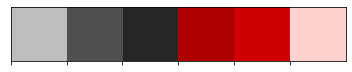

In [11]:
# 使用配色
palette = ['#BEBEBE','#4F4F4F', '#272727', '#AE0000','#CE0000','#FFD2D2']
sns.palplot(['#BEBEBE','#4F4F4F', '#272727', '#AE0000','#CE0000','#FFD2D2'])


In [12]:
# 中文字型
def plt_chinese():
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 修改中文字體
    plt.rcParams['axes.unicode_minus'] = False # 顯示負號
plt_chinese()

        2.1 電視 VS.電影


In [13]:
# 電視電影IP比例
type_ratio = (df.groupby(['type'])['type'].count() / len(df)).round(3) 
print('電視電影IP比例：\n', type_ratio)

# 電視電影實際數量比例
df['duration_number'] = df['duration'].str.split(' ').str[0].astype(int)
df['type_count'] = df.apply(lambda row: row['duration_number'] if row['type'] == 'TV Show' else 1, axis = 1)
type_ratio_weight = (df.groupby('type')['type_count'].sum() / df['type_count'].sum()).round(3)
print('\n電視電影實際產出數量比例：\n', type_ratio_weight)

電視電影IP比例：
 type
Movie      0.697
TV Show    0.303
Name: type, dtype: float64



電視電影實際產出數量比例：
 type
Movie      0.568
TV Show    0.432
Name: type_count, dtype: float64


Text(0.625, 0.15, '電視電影實際產出數量比例')

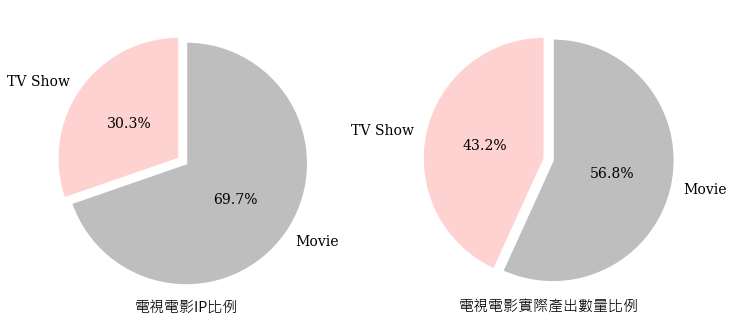

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
wedges, texts, autotexts = axs[0].pie(type_ratio, labels = type_ratio.index, autopct = '%1.1f%%',
                                      startangle = 90, counterclock = False, shadow = False, explode = (0.07, 0), 
                                      textprops = dict(fontfamily ='serif', fontsize = 14, color = 'black'),
                                      colors = [palette[0], palette[5]], labeldistance = 1.1, pctdistance = 0.5,
                                      wedgeprops = {"linewidth": 2, "edgecolor": "white"})
wedges, texts, autotexts = axs[1].pie(type_ratio_weight, labels = type_ratio_weight.index, autopct = '%1.1f%%',
                                      startangle = 90, counterclock = False, shadow = False, explode = (0.07, 0), 
                                      textprops = dict(fontfamily ='serif', fontsize = 14, color = 'black'),
                                      colors = [palette[0], palette[5]], labeldistance = 1.1, pctdistance = 0.5,
                                      wedgeprops = {"linewidth": 2, "edgecolor": "white"})
fig.text(0.25,0.15,'電視電影IP比例', fontsize = 15)
fig.text(0.625,0.15,'電視電影實際產出數量比例', fontsize = 15)
#fig.savefig('電視電影類型', transparent = True)

1. 這個資料集以每個 IP 當作一個資料(列)，當中電影占了將近七成，電視劇只佔了三成。
2. 若電視劇 IP 計算季數進行加總，電影總數依舊高於電視劇。不過電影佔了不到六成，電視劇提高至 43%。猜測與時間和金錢成本有關。
3. 由於電視劇可能有多季(分散在不同年)播出，卻只有一份資料，這導致無法看出電視劇逐年的產出與其他變化。因此我們以電影作為主要分析：

c:\Users\gary8\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


Text(0.5, 0, '季數')

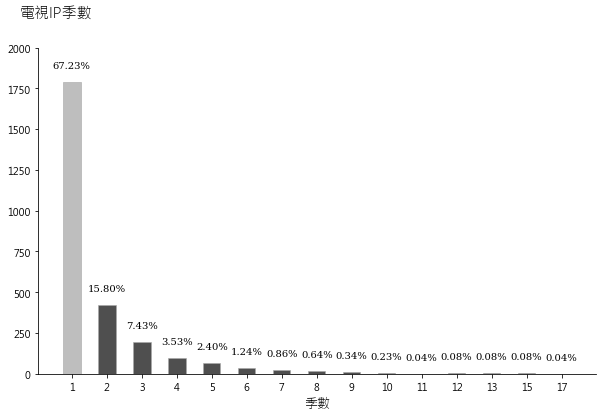

In [46]:
tv_duration_number = df.loc[df['type'] == 'TV Show', 'duration_number'].value_counts().sort_index()
tv_duration_number_ratio = (tv_duration_number / tv_duration_number.sum()).round(4)*100

color_map = [palette[1] for _ in range(10)]
color_map[0] = palette[0]

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(tv_duration_number.index.astype(str), tv_duration_number, width = 0.5, edgecolor = 'darkgray', linewidth = 0.6, color = color_map)

# 隱藏邊界
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
   
# 標籤字體
ax.set_xticklabels(tv_duration_number.index, rotation = 0)

# y軸範圍
ax.set_ylim(0,2000)

# 數字標示
for i in range(0, len(tv_duration_number.index)):
    ax.annotate(f"{tv_duration_number_ratio.iloc[i]:.2f}%", 
                   xy=(i, tv_duration_number.iloc[i] + 100), 
                   va = 'center', ha = 'center', fontweight = 'light', fontfamily = 'serif')

# 標題
fig.text(0.1, 0.95, '電視IP季數', fontsize = 15, fontweight = 'light')
ax.set_xlabel('季數', fontsize = 13, fontweight = 'light')


1. 截至2021年，電視劇有三分之二的比例是只有出單一季的，超過 9 季的不到 1% 的比例。最多有 17 季。
2. 將近三分之一的電視劇有續集，可能說明 IP 的強大促使後續有開發機會。

        2.2 國家發行量比較

In [16]:
# 所有類型發行量
df['country_list'] = df['country'].str.split(', ')
country_df = pd.DataFrame(df['country_list'].explode())
country_df['country_list'].replace('United States', 'USA', inplace = True)
country_df['country_list'].replace('United Kingdom', 'UK', inplace = True)
country_df['country_list'].replace('South Korea', 'Korea', inplace = True)

country_df['type_count'] = df['type_count']

#countries_count = country_df['country_list'].value_counts()
countries_count = country_df.groupby('country_list')['type_count'].sum().sort_values(ascending=False)
print("所有形式製作(共同 + 獨立):\n",countries_count[:15]) 

# 獨立製作發行量
df['country'].replace('United States', 'USA', inplace = True)
df['country'].replace('United Kingdom', 'UK', inplace = True)
df['country'].replace('South Korea', 'Korea', inplace = True)

#country_count = df.loc[(~df['country'].str.contains(',')), 'country'].value_counts()
country_count = df[(~df['country'].str.contains(','))].groupby('country')['type_count'].sum().sort_values(ascending=False)
print("\n獨立製作:\n",country_count[:15])

所有形式製作(共同 + 獨立):
 country_list
USA          5658
India        1119
UK           1056
Canada        677
France        462
Japan         440
Korea         297
Spain         282
Germany       246
Australia     217
Mexico        213
China         172
Turkey        134
Egypt         125
Nigeria       116
Name: type_count, dtype: int64

獨立製作:
 country
USA          4562
India        1039
UK            614
Japan         348
Canada        274
Korea         249
Spain         185
France        143
Australia     134
Mexico        125
Turkey        124
Egypt         113
Nigeria       107
Brazil         89
Taiwan         83
Name: type_count, dtype: int64


c:\Users\gary8\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
c:\Users\gary8\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0.65, 0.95, '獨立製作發行量前十名國家')

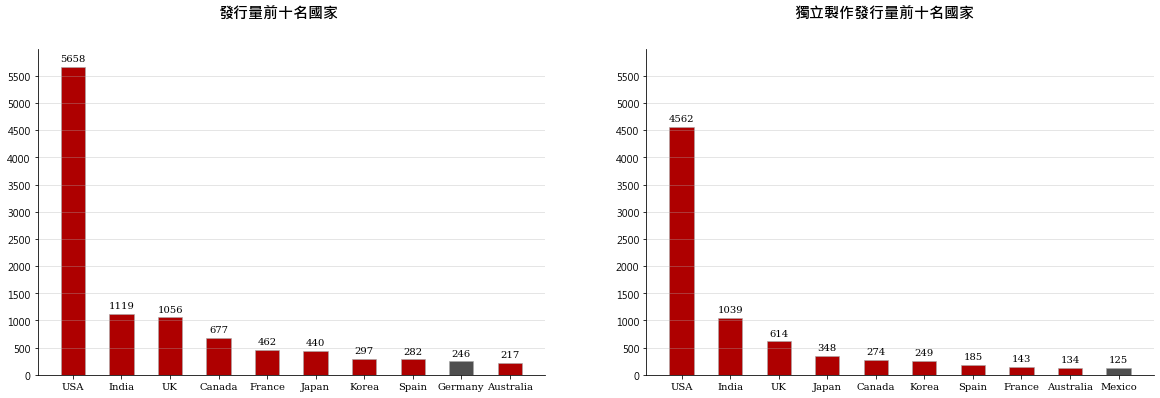

In [17]:
# 共同 & 獨立合作發行量

color_map1 = [palette[3] for _ in range(10)]
color_map2 = [palette[3] for _ in range(10)]
color_map1[8] = palette[1]
color_map2[9] = palette[1]
fig, ax = plt.subplots(1,2, figsize=(20, 6))
ax[0].bar(countries_count.index[:10], countries_count[:10], width = 0.5, edgecolor = 'darkgray', linewidth = 0.6, color = color_map1)
ax[1].bar(country_count.index[:10], country_count[:10], width = 0.5, edgecolor = 'darkgray', linewidth = 0.6, color = color_map2)

# 隱藏邊界
for s in ['top', 'right']:
    ax[0].spines[s].set_visible(False)
    ax[1].spines[s].set_visible(False)

# 標籤字體
ax[0].set_xticklabels(countries_count.index, fontfamily = 'serif', rotation = 0)
ax[1].set_xticklabels(country_count.index, fontfamily = 'serif', rotation = 0)

# y軸範圍
ax[0].set_ylim(0,6000)
ax[1].set_ylim(0,6000)

# 格線
ax[0].grid(axis='y', linestyle='-', alpha=0.4)
ax[1].grid(axis='y', linestyle='-', alpha=0.4)

# 數字標示
for i in countries_count.index:
    ax[0].annotate(f"{countries_count[i]}", 
                   xy=(i, countries_count[i] + 150), #i like to change this to roughly 5% of the highest cat
                   va = 'center', ha='center',fontweight='light', fontfamily='serif')

for i in country_count.index:
    ax[1].annotate(f"{country_count[i]}", 
                   xy=(i, country_count[i] + 150), #i like to change this to roughly 5% of the highest cat
                   va = 'center', ha='center',fontweight='light', fontfamily='serif')

# y軸間距
grid_y_ticks = np.arange(0, 6000, 500) # y ticks, min, max, then step
ax[0].set_yticks(grid_y_ticks)
ax[1].set_yticks(grid_y_ticks)

# 標題
fig.text(0.25, 0.95, '發行量前十名國家', fontsize = 15, fontweight = 'bold')
fig.text(0.65, 0.95, '獨立製作發行量前十名國家', fontsize = 15, fontweight = 'bold')

1. 九個國家：美國、印度、英國、加拿大、法國、日本、韓國、西班牙、澳洲無論是獨立製作或是共同合作，其發行量皆能佔據前十名。
2. 美國的發行量遙遙領先其餘國家，除了說明擁有龐大的影視市場之外，平台源自於美國也是一個很大的因素。
3. 印度獨立製作發行量高，但相較於前十名的其他國家，共同製作發行量較少。反之，德國甚至有超過半數的發行都是與他國合作。

c:\Users\gary8\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


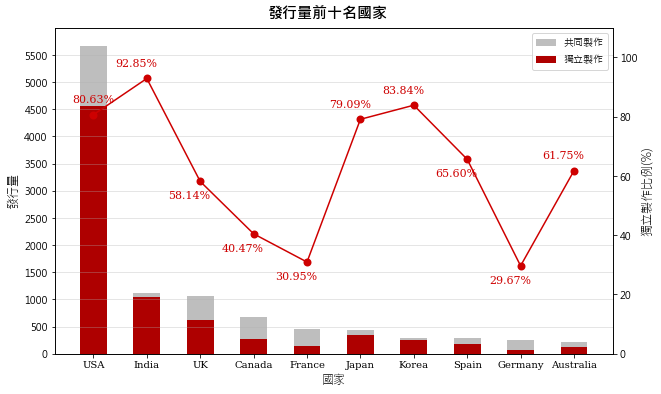

In [76]:
# 共同 & 獨立製作發行量
percentage_ind = (country_count[countries_count.index[:10]]/countries_count[:10]).round(4) * 100 

color_map_coo = [palette[0] for _ in range(10)]
color_map_ind = [palette[3] for _ in range(10)]

fig, ax = plt.subplots(1,1, figsize=(10, 6))
ax2 = ax.twinx()

coo = ax.bar(countries_count.index[:10], countries_count[:10], 
             width = 0.5, linewidth = 0.6, color = color_map_coo)

ind = ax.bar(countries_count.index[:10], country_count[countries_count.index[:10]], 
             width = 0.5, linewidth = 0.6, color = color_map_ind)

ind_ratio = ax2.plot(countries_count.index[:10], percentage_ind, 
                     color = palette[4], ls = '-' , marker = '.', mew = 5)

# 水平線
#ax2.axhline(y = 70, color = '#CE0000', linestyle = '--', linewidth = 1)

# 標籤字體
ax.set_xticklabels(countries_count.index, fontfamily = 'serif', rotation = 0)

# y軸範圍

ax.set_ylim(0,6000)
ax2.set_ylim(0,110)

# 格線
ax.grid(axis='y', linestyle='-', alpha=0.4)

# 數字標示 
ax2.annotate(f"{percentage_ind[0]:.2f}%", 
             xy=(0, percentage_ind[0] + 5), 
             va = 'center', ha = 'center',fontweight = 'light', fontfamily = 'serif', fontsize = 11, color = palette[4])

for j in range(1,10):
    i = countries_count.index[j]
    if percentage_ind[j] > percentage_ind[(j-1)]:
        ax2.annotate(f"{percentage_ind[i]:.2f}%", xy=(j - 0.2, percentage_ind[i] + 5), 
                     va = 'center', ha = 'center',fontweight = 'light', fontfamily = 'serif', fontsize = 11, color = palette[4])
    else:
        ax2.annotate(f"{percentage_ind[i]:.2f}%", xy=(j - 0.2, percentage_ind[i] - 5), 
                     va = 'center', ha = 'center',fontweight = 'light', fontfamily = 'serif', fontsize = 11, color = palette[4])  
          
# y軸間距
grid_y_ticks = np.arange(0, 6000, 500) 
ax.set_yticks(grid_y_ticks)

# 標題
fig.text(0.42, 0.9, '發行量前十名國家', fontsize = 15, fontweight = 'bold')

# 子標題
ax.set_ylabel('發行量', fontsize = 12, fontweight = 'light')
ax.set_xlabel('國家', fontsize = 12, fontweight = 'light')
ax2.set_ylabel('獨立製作比例(%)', fontsize = 12, fontweight = 'light')

# 圖例
ax.legend(handles = [coo, ind], labels = ['共同製作','獨立製作'])

1. 有些國家雖獨立製作量較少，透過共同合作反而衝高了發行量。
2. 亞洲地區偏好獨立製作(印度、日本、韓國獨立製作皆在前四名)，可能跟地理環境或語言因素有關；歐美地區則有較頻繁的交流合作。
3. 美國不論是獨立製作或合作量皆大幅先其他國家。

        2.3 國家發行類型 IP 比例

In [19]:
# 國家獨立發行類型比例
df['country_produce'] = ['Individual' if ',' not in i  else 'Cooperation' for i in df['country'] ]
top_10_country = countries_count.index[:10]
condition = (df['country'].isin(top_10_country)) & (df['country_produce'] == 'Individual')
individual_type = df.loc[condition,['type','country']].groupby('country')['type'].value_counts().unstack().loc[top_10_country]
individual_type_ratio = (individual_type.T/individual_type.sum(axis = 1)).T[['Movie','TV Show']].sort_values(by = 'Movie', ascending = False)[::-1]
individual_type


type,Movie,TV Show
country_list,,
USA,2381,1123
India,947,79
UK,210,213
Canada,122,59
France,76,49
Japan,84,167
Korea,42,173
Spain,97,49
Germany,48,20


In [20]:
# 國家合作發行類型比例

country_df['type'] = df['type']
country_df['country_produce'] = df['country_produce']

condition2 = (country_df['country_list'].isin(top_10_country)) & (country_df['country_produce'] == 'Cooperation')

cooperation_type = country_df.loc[condition2,['type', 'country_list']].groupby('country_list')['type'].value_counts().unstack().loc[top_10_country]
cooperation_type_ratio = (cooperation_type.T / cooperation_type.sum(axis = 1)).T[['Movie','TV Show']].sort_values(by = 'Movie', ascending = False)[::-1]
cooperation_type

type,Movie,TV Show
country_list,,
USA,699,178
India,71,5
UK,330,59
Canada,200,67
France,231,42
Japan,43,30
Korea,21,12
Spain,76,13
Germany,135,24


c:\Users\gary8\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
c:\Users\gary8\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator


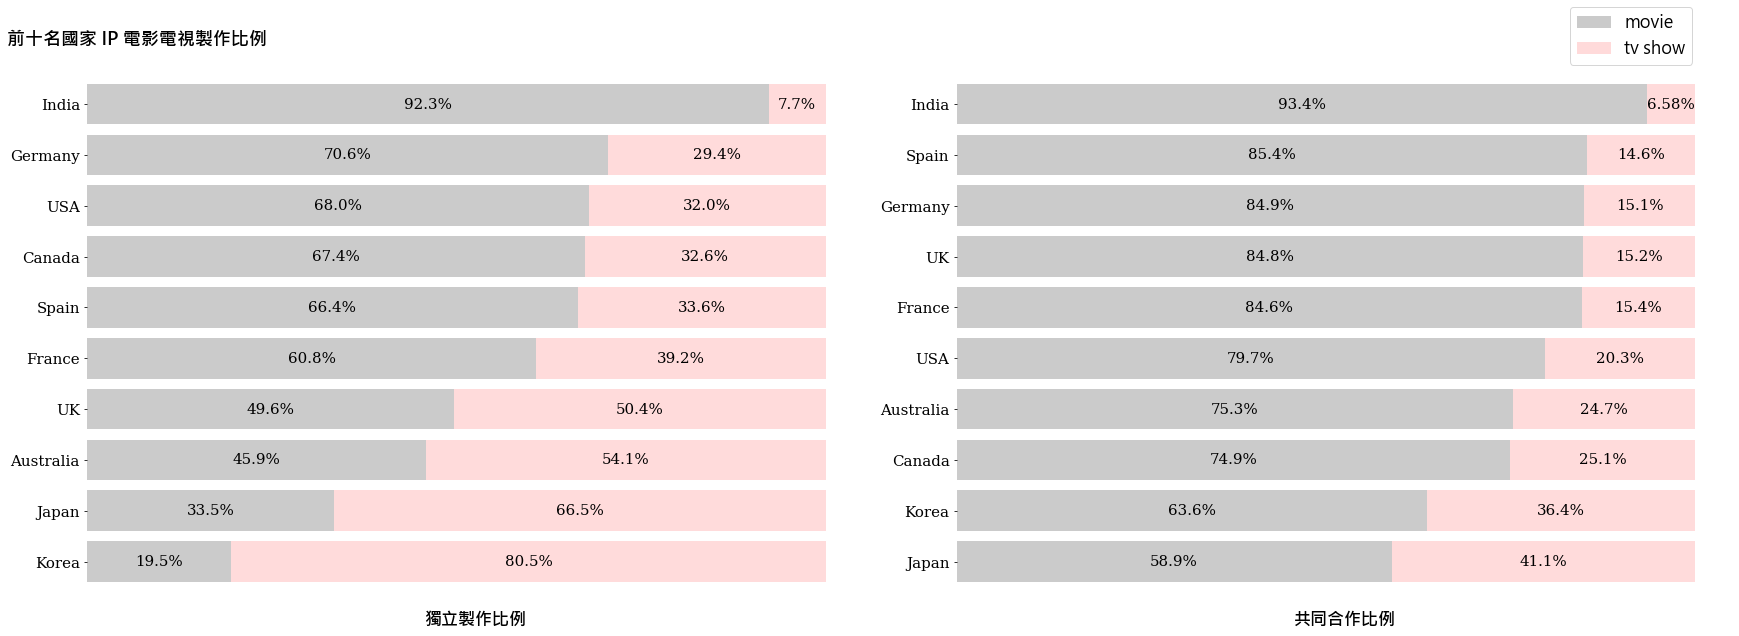

In [67]:
fig, ax = plt.subplots(1, 2, figsize = (24,8), layout ='constrained')

# 長條圖
ax[0].barh(individual_type_ratio.index, individual_type_ratio['Movie'],
        color = palette[0], alpha = 0.8)
ax[0].barh(individual_type_ratio.index, individual_type_ratio['TV Show'], left = individual_type_ratio['Movie'],
        color = palette[5], alpha = 0.8)

# 標籤
ax[0].set_xticks([])
ax[0].set_yticklabels(individual_type_ratio.index, fontfamily = 'serif', fontsize = 15)
ax[0].set_xlabel('獨立製作比例', fontsize = 17, fontweight = 'bold')

# 數字標示
for i in individual_type_ratio.index:
    ax[0].annotate(f"{individual_type_ratio['Movie'][i] * 100:.3}%", 
                xy = (individual_type_ratio['Movie'][i]/2,i),
                va ='center', ha = 'center',fontsize = 15, fontfamily = 'serif', fontweight='light', color = 'black' )
    
    ax[0].annotate(f"{individual_type_ratio['TV Show'][i] * 100:.3}%", 
                xy = (individual_type_ratio['Movie'][i] + individual_type_ratio['TV Show'][i]/2,i),
                va ='center', ha = 'center',fontsize = 15, fontfamily = 'serif', fontweight='light', color = 'black' )

# 長條圖
movie = ax[1].barh(cooperation_type_ratio.index, cooperation_type_ratio['Movie'], 
                          color = palette[0], alpha = 0.8, label='movie')
tvshow = ax[1].barh(cooperation_type_ratio.index, cooperation_type_ratio['TV Show'], left = cooperation_type_ratio['Movie'],
        color = palette[5], alpha = 0.8, label='tv show')

# 標籤
ax[1].set_xticks([])
ax[1].set_yticklabels(cooperation_type_ratio.index, fontfamily = 'serif', fontsize = 15)
ax[1].set_xlabel('共同合作比例', fontsize = 17, fontweight = 'bold')

# 數字標示
for i in cooperation_type_ratio.index:
    ax[1].annotate(f"{cooperation_type_ratio['Movie'][i] * 100:.3}%", 
                xy = (cooperation_type_ratio['Movie'][i]/2,i),
                va ='center', ha = 'center',fontsize = 15, fontfamily = 'serif', fontweight='light', color = 'black' )
    
    ax[1].annotate(f"{cooperation_type_ratio['TV Show'][i] * 100:.3}%", 
                xy = (cooperation_type_ratio['Movie'][i] + cooperation_type_ratio['TV Show'][i]/2,i),
                va ='center', ha = 'center',fontsize = 15, fontfamily = 'serif', fontweight='light', color = 'black' )

# 標題
fig.text(0.,1.02,'前十名國家 IP 電影電視製作比例', fontsize = 18, fontweight = 'bold')  

# 邊框
for s in ['top', 'left', 'right', 'bottom']:
    ax[0].spines[s].set_visible(False)
    ax[1].spines[s].set_visible(False)     


# 圖例
fig.legend(handles = [movie, tvshow],  bbox_to_anchor = (0.98,1.1), fontsize = 17)



1. 在獨立製作日本、韓國的部分有極大比例的電視節目，蠻符合我們對於日劇韓劇眾多的印象；歐美地區則偏好出產較多的電影，大約佔了六、七成；印度廣為人知的便是電影，也反映在類型比較數據上!
2. 在跨國合作的部分，發行量前十大的國家皆有超過半數的比例是進行電影的合作，或許是金錢與時間成本的考量。歐美相對於日韓依舊有較高的比例進行電影的合作。

        2.4 每年發行量

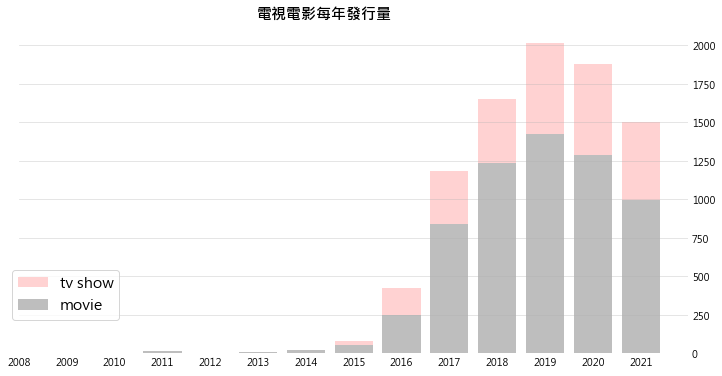

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# 折線圖填滿
year_movie = df.loc[df['type'] == 'Movie', 'year_add'].value_counts().sort_index()
year_tv = df.loc[df['type'] == 'TV Show', 'year_add'].value_counts().sort_index()
year_type = year_movie.add(year_tv, fill_value = 0)

ax.bar(year_type.index, year_type, color = palette[5], label = 'tv show')
ax.bar(year_movie.index, year_movie, color = palette[0], label = 'movie')

# y軸
ax.yaxis.tick_right()

# x軸
ax.set_xlim(2008,2022)
plt.xticks(np.arange(2008,2021.5,1))

# 格線
ax.grid(axis='y', linestyle='-', alpha=0.4)

# 標籤線
ax.tick_params(axis = u'both', which = u'both', length = 0)

# 邊界
for s in ['top', 'right','bottom','left']:
    ax.spines[s].set_visible(False)
#ax.grid(axis='y', linestyle='--', alpha=0.4)
    
# 標題
fig.text(0.4, 0.9, '電視電影每年發行量', fontsize = 15, fontweight = 'bold')

# 圖例
fig.legend(bbox_to_anchor = (0.25,0.335), fontsize = 15)


1. 從 2015 年開始發行量急遽地增加，原因為 Netflix 將主力改成提供網路影片串流服務。2019 年結束後開始下降，可能是受到疫情的影響。
2. 由於無法得知電視劇每一季的年份，因此其帳面上的發行量會比實際來的少。

        2.5 影片種類

In [93]:
df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(','))
genre_df = pd.DataFrame(df['genre'].explode())
genre_df['type'] = df['type']
genre_movie = genre_df.loc[df['type'] == 'Movie', 'genre'].value_counts()
genre_tvshow = genre_df.loc[df['type'] == 'TV Show', 'genre'].value_counts()
print('Movie:\n',genre_df.loc[df['type'] == 'Movie', 'genre'].value_counts())
print('TV Show:\n',genre_df.loc[df['type'] == 'TV Show', 'genre'].value_counts())

Movie:
 International Movies        2752
Dramas                      2426
Comedies                    1674
Documentaries                869
Action & Adventure           859
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
Thrillers                    577
Music & Musicals             375
Horror Movies                357
Stand-Up Comedy              343
Sci-Fi & Fantasy             243
Sports Movies                219
Classic Movies               116
LGBTQ Movies                 102
Anime Features                71
Cult Movies                   71
Faith & Spirituality          65
Movies                        53
Name: genre, dtype: int64
TV Show:
 International TV Shows          1349
TV Dramas                        762
TV Comedies                      573
Crime TV Shows                   469
Kids' TV                         448
Docuseries                       394
Romantic TV Shows                370
Reality TV                       255


1. 想要了解電視電影是依怎樣的劇情分類，所以刪除以地區或年齡分類的類型。

In [108]:
# 刪除以地區或年齡分類的類型
rows_to_drop_movie = ['International Movies', "Independent Movies", "Movies"]
rows_to_drop_tvshow = ['International TV Shows', "Kids' TV", 'British TV Shows', 'Spanish-Language TV Shows', 'Korean TV Shows', 'Teen TV Shows', 'TV Shows']

# 删除行
#genre_movie.drop(index=rows_to_drop_movie, inplace=True)
#genre_tvshow.drop(index=rows_to_drop_tvshow, inplace=True)
print('Movie:\n', genre_movie)
print('TV Show:\n', genre_tvshow)

Movie:
 Dramas                      2426
Comedies                    1674
Documentaries                869
Action & Adventure           859
Children & Family Movies     641
Romantic Movies              616
Thrillers                    577
Music & Musicals             375
Horror Movies                357
Stand-Up Comedy              343
Sci-Fi & Fantasy             243
Sports Movies                219
Classic Movies               116
LGBTQ Movies                 102
Anime Features                71
Cult Movies                   71
Faith & Spirituality          65
Name: genre, dtype: int64
TV Show:
 TV Dramas                       762
TV Comedies                     573
Crime TV Shows                  469
Docuseries                      394
Romantic TV Shows               370
Reality TV                      255
Anime Series                    174
TV Action & Adventure           167
TV Mysteries                     98
Science & Nature TV              92
TV Sci-Fi & Fantasy              83

c:\Users\gary8\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
c:\Users\gary8\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


Text(0.4, 0.9, '電視電影種類')

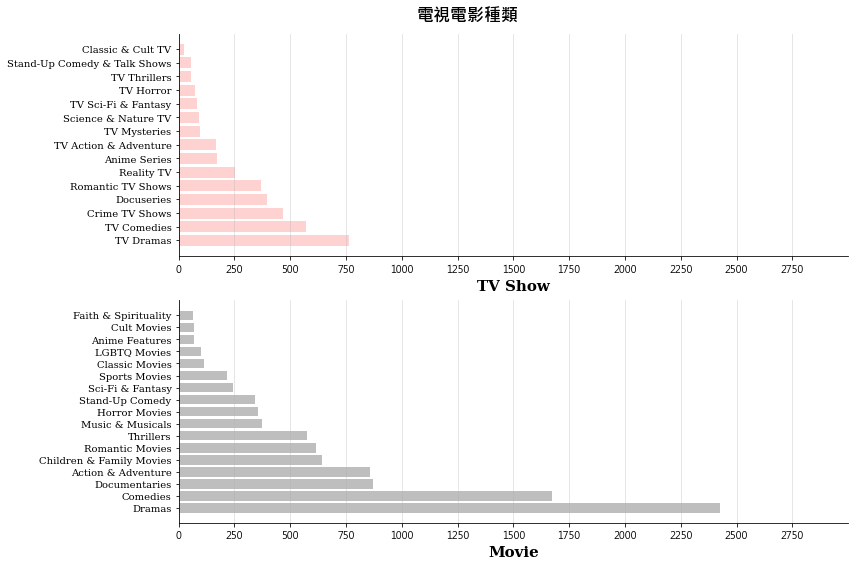

In [116]:
fig, axs = plt.subplots(2,1, figsize = (12, 9))

axs[0].barh(genre_tvshow.index, genre_tvshow, color = palette[5])
axs[1].barh(genre_movie.index, genre_movie, color = palette[0] )

# x軸
#axs[0].set_xticks(x + width, month_type.index)
#ax.set_xticklabels(month_type.index, fontfamily = 'serif')
axs[0].set_xlim(0,3000)
axs[1].set_xlim(0,3000)

# y軸
axs[0].set_yticklabels(genre_tvshow.index, fontfamily = 'serif')
axs[1].set_yticklabels(genre_movie.index, fontfamily = 'serif')


# 隱藏邊界
for s in ['top', 'right']:
    axs[0].spines[s].set_visible(False)
    axs[1].spines[s].set_visible(False)

# 標籤字體
#axs[0].set_xticklabels(countries_count.index, fontfamily = 'serif', rotation = 0)
#axs[1].set_xticklabels(country_count.index, fontfamily = 'serif', rotation = 0)

# 格線
axs[0].grid(axis = 'x', linestyle = '-', alpha = 0.4)
axs[1].grid(axis = 'x', linestyle = '-', alpha = 0.4)

# x軸間距
grid_x_ticks = np.arange(0, 3000, 250) 
axs[0].set_xticks(grid_x_ticks)
axs[1].set_xticks(grid_x_ticks)

# 標籤
axs[0].set_xlabel('TV Show', fontsize = 15, fontfamily = 'serif', fontweight = 'bold')
axs[1].set_xlabel('Movie', fontsize = 15, fontfamily = 'serif', fontweight = 'bold')

# 標題
fig.text(0.4, 0.9, '電視電影種類', fontsize = 17, fontweight = 'bold')


1. 電視劇和電影皆以 Dramas 、 Comedies 和 Documentaries 為大宗，比較像是影片的形式(或是拍攝手法)。而 Cult 的類型都比較冷門。
2. 相較於電影，電視劇比較不偏好拍攝驚悚與恐怖的類型。


        2.6 類型相關性

There are 20 types in the Netflix Movie Dataset


c:\Users\gary8\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


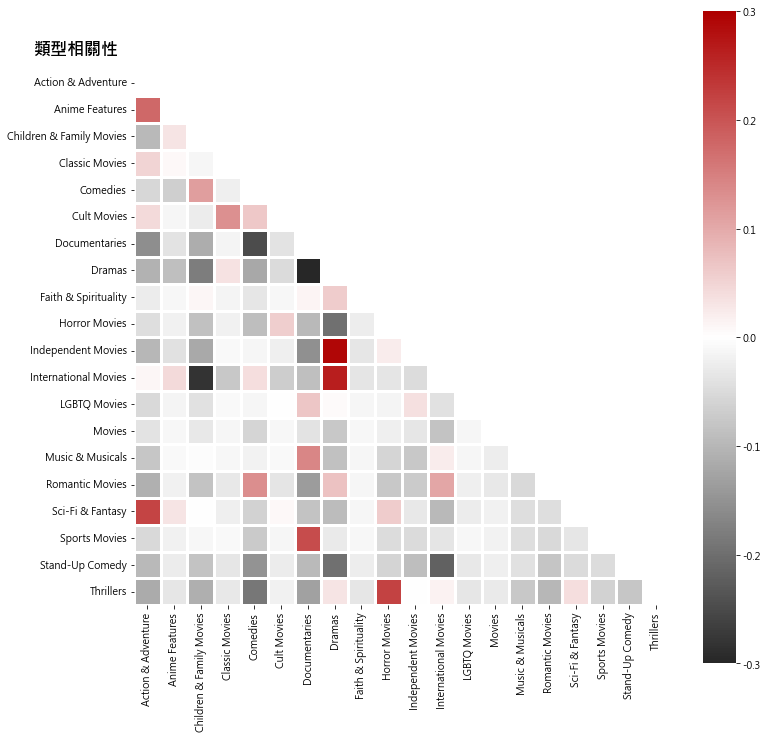

In [115]:
from sklearn.preprocessing import MultiLabelBinarizer 
import matplotlib.colors

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [palette[2], 'white', palette[3]])

df_tv = df[df["type"] == "TV Show"]
df_movies = df[df["type"] == "Movie"]
title ='Movie'

Types = []
for i in df_movies['genre']: Types += i
Types = set(Types)
print("There are {} types in the Netflix {} Dataset".format(len(Types),title))    
test = df_movies['genre']
mlb = MultiLabelBinarizer()
res = pd.DataFrame(mlb.fit_transform(test), columns = mlb.classes_, index = test.index)
corr = res.corr()
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize = (12, 12))
fig.text(.01 ,.83 ,'類型相關性', fontweight = 'bold', fontsize = 17)
pl = sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, vmin = -.3, center = 0, square = True, linewidths = 2.5)

plt.show()

1. International Movies 和 Individualal Movies 分別與 Dramas 呈明顯正向關係(紅色)。Thrillers 和 Horror Movies也同樣是呈明顯正向關係。
2. International Movies 和 Children & Family Movies 與 Dramas 呈明顯負向關係(黑色)。Dramas 和  Documentaries也同樣是呈明顯負向關係。

        2.7 文字雲

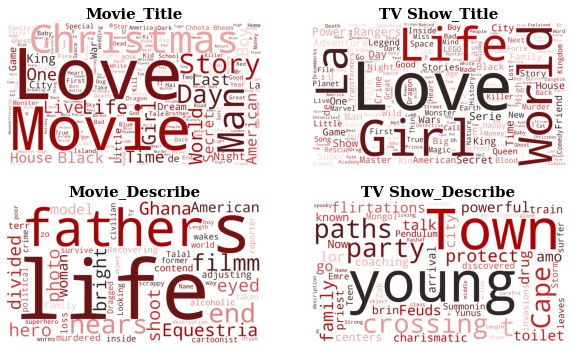

In [137]:
# 文字雲
from wordcloud import WordCloud

text_movie = str(df.loc[df['type'] == 'Movie', 'description'])
title_movie = str(list(df.loc[df['type'] == 'Movie', 'title'])).replace(',', '').replace('[', '').replace("'", '').replace(']', '').replace('.', '')

text_tvshow = str(df.loc[df['type'] == 'TV Show', 'description'])
title_tvshow = str(list(df.loc[df['type'] == 'TV Show', 'title'])).replace(',', '').replace('[', '').replace("'", '').replace(']', '').replace('.', '')

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [palette[5], palette[3], palette[2]])
fig,ax = plt.subplots(2, 2, figsize=(10,6))
wordcloud_movie = WordCloud(background_color = 'White', width = 1920, height = 1080, colormap = cmap).generate(text_movie)
wordcloud_movie_title = WordCloud(background_color = 'White', width = 1920, height = 1080, colormap = cmap).generate(title_movie)
wordcloud_tvshow = WordCloud(background_color = 'White', width = 1920, height = 1080, colormap = cmap).generate(text_tvshow)
wordcloud_tvshow_title = WordCloud(background_color = 'White', width = 1920, height = 1080, colormap = cmap).generate(title_tvshow)

ax[0,0].imshow(wordcloud_movie_title)
ax[1,0].imshow(wordcloud_movie)
ax[0,1].imshow(wordcloud_tvshow_title)
ax[1,1].imshow(wordcloud_tvshow)

ax[0,0].axis('off')
ax[1,0].axis('off')
ax[0,1].axis('off')
ax[1,1].axis('off')

ax[0,0].set_title('Movie_Title', fontweight = 'bold', fontsize = 15, fontfamily = 'serif')
ax[1,0].set_title('Movie_Describe', fontweight = 'bold', fontsize = 15, fontfamily = 'serif')
ax[0,1].set_title('TV Show_Title', fontweight = 'bold', fontsize = 15, fontfamily = 'serif')
ax[1,1].set_title('TV Show_Describe', fontweight = 'bold', fontsize = 15, fontfamily = 'serif')

#plt.savefig('cast.png')
plt.show()

1. 電視劇與電影的標題的主要關鍵詞同樣有 Love、Life、World、Girl。
2. 電視劇與電影的內容描述的關鍵詞有著極大差異。